In [1]:
import os
import subprocess
import rasterio
import json
import tempfile
import math
import shapely

import pandas as pd
import geopandas as geopd
import numpy as np
import matplotlib.pyplot as plt


from shapely.geometry import Point
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.features import rasterize
from IPython.display import display

%matplotlib inline
plt.rcParams['figure.dpi'] = 300

In [19]:
""""""
# Vain virhe-esimerkille
""""""

# Changes between old and new
squares_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/grids/error_example_grid.gpkg"
annotations_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/virhe_esimerkit/virhe-esimerkit.gpkg"
# Changes between old and new
raster_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/clip_kartat/newer_v2.vrt"
""" jokainen kilometrin ruutu sisältää 590,5 pikseliä, jota lähin kahdella riittävästi  jakautuva luku on 576.
Näin ollen saadaan neljä kuvaa kuvakoolla 288 x 288 (kuvat pidetään pieninä jotta pieneet kohteet huomataan paremmin)
Tämä koko sallii 5 jakoa kakkosella, mikä riittää U-nettiin.
otosten keskukset ovat näin ollen 145 pikseliä reunasta (reunaefektien välttämiseksi), jolloin reunaan jää yhden pikselin kolo
"""
# Not the actual value, fine tuned to create right sized image output
pixel_size = 1.685
# Valid range is 145 – 150
sample_offset_px = 145

image_tmp_dir = "/tmp/images"
label_tmp_dir = "/tmp/labels"
#train_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/virhe_esimerkit/elijärvi"
#train_label_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/opetusannotaatiot"
test_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/virhe_esimerkit/kuva"
test_label_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/virhe_esimerkit/etiketti"
dirs = [image_tmp_dir, label_tmp_dir, test_dir, test_label_dir]

for directory in dirs:
    if not os.path.isdir(directory):
        os.mkdir(directory)


offset_substraction = sample_offset_px - 144
sample_offset_m = pixel_size * sample_offset_px
sample_buffer_size_m = pixel_size * (sample_offset_px - offset_substraction)

squares = geopd.read_file(squares_path)
# Changes between old and new
annotations = geopd.read_file(annotations_path, layer="digitoinnit")

In [21]:
""""""
# Vain virhe-esimerkille
""""""

# Counter for the training samples, starts from 909 with older data
j=0

# not efficient but the amount of points is relatively small and the code is run only once
errors = []
# Counting starts from 303 for older data
for i, square in enumerate(squares.iterrows(), 0):

    
    # Image tmp path
    image_path = os.path.join(image_tmp_dir, str(i) + '.tif')
    #  Label tmp path
    
    poly = (square[-1]['geometry'])
    corner_points = [k for k in list(poly.exterior.coords)]
    x_W, y_N = corner_points[0]
    x_E, y_S = corner_points[2]
    print(x_W, y_N, x_E, y_S)
    NW_sample = Point(x_W + sample_offset_m, y_N - sample_offset_m)
    NE_sample = Point(x_E - sample_offset_m, y_N - sample_offset_m)
    SE_sample = Point(x_E - sample_offset_m, y_S + sample_offset_m)
    SW_sample = Point(x_W + sample_offset_m, y_S + sample_offset_m)
    sample_points = geopd.GeoSeries([NW_sample, NE_sample, SE_sample, SW_sample])
    # Square buffer
    sample_squares = sample_points.buffer(sample_buffer_size_m, cap_style=3)
    # 3 out of 4 images are used for training 
    training_squares = sample_squares[0:3]
    """ the SW corner of all images is reserved for testing, which makes test data reliable
    There is often older and newer version, this makes sure that same location is sampled for testing in both cases.
    Thus model cannot get any information about the testing plot.
    """
    testing_square = sample_squares[3]
    with rasterio.open(raster_path) as src:
        # Opens only the required, very small area instead of the entire huge raster. Alpha band is not needed as it is only for visualisations
        raster = src.read((1,2,3), boundless=True, window=from_bounds(left=x_W, bottom=y_S, right=x_E, top=y_N, transform=src.transform))
        meta = src.meta.copy()
        
    # Constructing the correct transform for the window area
    meta['transform'] = rasterio.transform.from_bounds(west=x_W, south=y_S, east=x_E, north=y_N, width=raster.shape[1], height=raster.shape[2])
    meta['width'] = raster.shape[1]
    meta['height'] = raster.shape[2]
    meta['count'] = 3
    # The results are saved as geotiff
    meta['driver'] = "GTiff"
    
    # Saving the image and reopening it to get it ready for clipping
    with rasterio.open(image_path, 'w', **meta) as dest:
        dest.write(raster)

    with rasterio.open(image_path) as image:
        
        sample_meta = image.meta.copy()
        # Clipping the 3 training samples and saving them
        """
        for sample in training_squares:
            
            sample_path = os.path.join(train_dir, str(j) + '.tif')
            label_path = os.path.join(train_label_dir, str(j) + '.tif')
            bbox=[sample]
            sample_image, sample_meta['transform']=mask(image, bbox, all_touched=True, crop=True)
            sample_meta['width'] = sample_image.shape[1]
            sample_meta['height'] = sample_image.shape[2]
            label_meta = sample_meta.copy()
            label_meta['count'] = 1
            # Saving the clip
            with rasterio.open(sample_path, 'w', **sample_meta) as dest:
                dest.write(sample_image)

            
            clipped_annotation = geopd.clip(annotations, sample)
            clipped_annotation = [(geom, value) for geom, value in zip(clipped_annotation.geometry, clipped_annotation['Täyttöarvo'])]
            # Creating the labels
            try:
                rasterized_annotation = rasterize(clipped_annotation, out_shape=(sample_meta['width'], sample_meta['height']), transform=sample_meta['transform'], dtype=sample_image.dtype)
                rasterized_annotation = np.reshape(rasterized_annotation, (1, sample_meta['width'], sample_meta['height']))
            # Happens if none of the classes are present in the image area
            except Exception as error:
                errors.append(error)
                rasterized_annotation = np.zeros((1, sample_meta['width'], sample_meta['height']), dtype=sample_image.dtype)

            # Saving the label
            with rasterio.open(label_path, 'w', **label_meta) as dest:
                dest.write(rasterized_annotation)


            j += 1
        """
        # Clipping the test sample of the image
        sample_path = os.path.join(test_dir, str(i) + '.tif')
        label_path = os.path.join(test_label_dir, str(i) + '.tif')
        bbox=[testing_square]
        sample_image, sample_meta['transform']=mask(image, bbox, all_touched=True, crop=True)
        sample_meta['width'] = sample_image.shape[1]
        sample_meta['height'] = sample_image.shape[2]
        label_meta = sample_meta.copy()
        label_meta['count'] = 1
        
        with rasterio.open(sample_path, 'w', **sample_meta) as dest:
            dest.write(sample_image)
            
        clipped_annotation = geopd.clip(annotations, testing_square)
        clipped_annotation = [(geom, value) for geom, value in zip(clipped_annotation.geometry, clipped_annotation['Täyttöarvo'])]
        # Creating the labels
        try:
            rasterized_annotation = rasterize(clipped_annotation, out_shape=(sample_meta['width'], sample_meta['height']), transform=sample_meta['transform'], dtype=sample_image.dtype)
            rasterized_annotation = np.reshape(rasterized_annotation, (1, sample_meta['width'], sample_meta['height']))
        # Happens if none of the classes are present in the image area
        except Exception as error:
            errors.append(error)
            rasterized_annotation = np.zeros((1, sample_meta['width'], sample_meta['height']), dtype=sample_image.dtype)

        # Saving the label
        with rasterio.open(label_path, 'w', **label_meta) as dest:
            dest.write(rasterized_annotation)
        """
        fig, ax = plt.subplots()
        show(image, ax=ax)
        sample_squares.boundary.plot(ax=ax, color = 'blue', linewidth=0.5)
        """

394710.62252597307 7297990.713773869 395710.62252597307 7296990.713773869
355102.1441908346 7088436.077615028 356102.1441908346 7087436.077615028


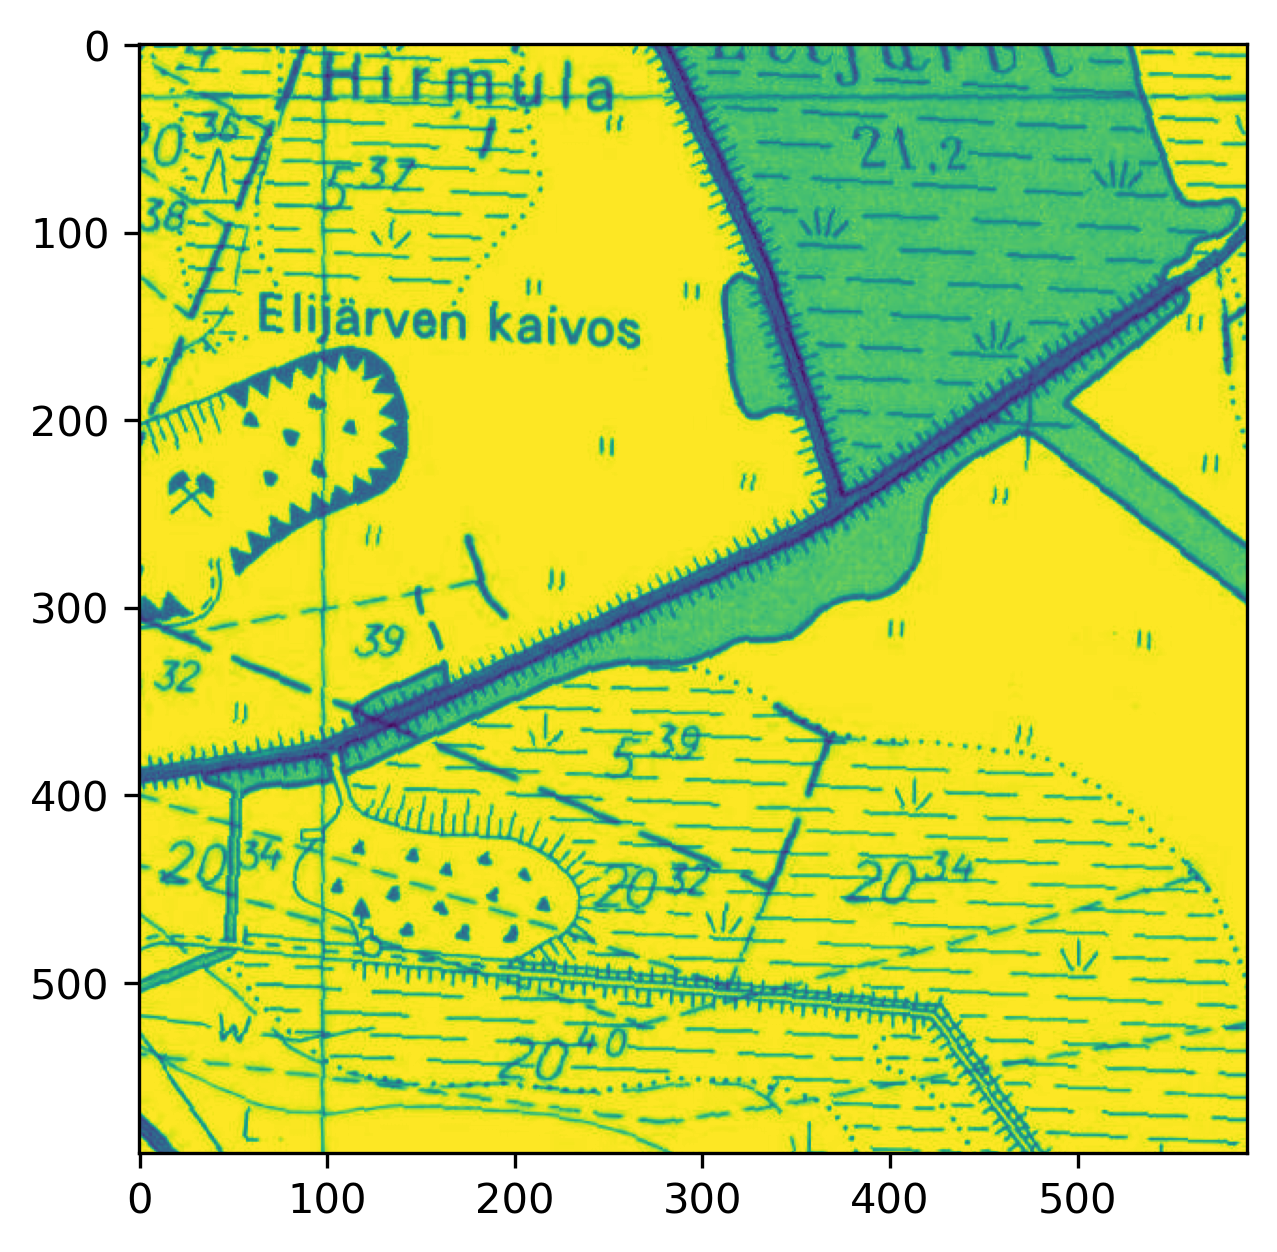

In [15]:
plt.imshow(raster[1])

In [ ]:
# Changes between old and new
squares_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/grids/uudet opetusruudut.gpkg"
annotations_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/digitointi/digitoinnit.gpkg"
# Changes between old and new
raster_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/clip_kartat/newer_v2.vrt"
""" jokainen kilometrin ruutu sisältää 590,5 pikseliä, jota lähin kahdella riittävästi  jakautuva luku on 576.
Näin ollen saadaan neljä kuvaa kuvakoolla 288 x 288 (kuvat pidetään pieninä jotta pieneet kohteet huomataan paremmin)
Tämä koko sallii 5 jakoa kakkosella, mikä riittää U-nettiin.
otosten keskukset ovat näin ollen 145 pikseliä reunasta (reunaefektien välttämiseksi), jolloin reunaan jää yhden pikselin kolo
"""
# Not the actual value, fine tuned to create right sized image output
pixel_size = 1.685
# Valid range is 145 – 150
sample_offset_px = 145

image_tmp_dir = "/tmp/images"
label_tmp_dir = "/tmp/labels"
train_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/opetus"
train_label_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/opetusannotaatiot"
test_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/testi"
test_label_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/testausannotaatiot"
dirs = [image_tmp_dir, label_tmp_dir ,train_dir, test_dir, train_label_dir, test_label_dir]

for directory in dirs:
    if not os.path.isdir(directory):
        os.mkdir(directory)


offset_substraction = sample_offset_px - 144
sample_offset_m = pixel_size * sample_offset_px
sample_buffer_size_m = pixel_size * (sample_offset_px - offset_substraction)

squares = geopd.read_file(squares_path)
# Changes between old and new
annotations = geopd.read_file(annotations_path, layer="Kaikki uudet")

In [3]:
# Counter for the training samples, starts from 909 with older data
j=0

# not efficient but the amount of points is relatively small and the code is run only once
errors = []
# Counting starts from 303 for older data
for i, square in enumerate(squares.iterrows(), 0):

    
    # Image tmp path
    image_path = os.path.join(image_tmp_dir, str(i) + '.tif')
    #  Label tmp path
    
    poly = (square[-1]['geometry'])
    corner_points = [i for i in list(poly.exterior.coords)]
    x_W, y_N = corner_points[0]
    x_E, y_S = corner_points[2]
    NW_sample = Point(x_W + sample_offset_m, y_N - sample_offset_m)
    NE_sample = Point(x_E - sample_offset_m, y_N - sample_offset_m)
    SE_sample = Point(x_E - sample_offset_m, y_S + sample_offset_m)
    SW_sample = Point(x_W + sample_offset_m, y_S + sample_offset_m)
    sample_points = geopd.GeoSeries([NW_sample, NE_sample, SE_sample, SW_sample])
    # Square buffer
    sample_squares = sample_points.buffer(sample_buffer_size_m, cap_style=3)
    # 3 out of 4 images are used for training 
    training_squares = sample_squares[0:3]
    """ the SW corner of all images is reserved for testing, which makes test data reliable
    There is often older and newer version, this makes sure that same location is sampled for testing in both cases.
    Thus model cannot get any information about the testing plot.
    """
    testing_square = sample_squares[3]
    with rasterio.open(raster_path) as src:
        # Opens only the required, very small area instead of the entire huge raster. Alpha band is not needed as it is only for visualisations
        raster = src.read((1,2,3), boundless=True, window=from_bounds(left=x_W, bottom=y_S, right=x_E, top=y_N, transform=src.transform))
        meta = src.meta.copy()
        
    # Constructing the correct transform for the window area
    meta['transform'] = rasterio.transform.from_bounds(west=x_W, south=y_S, east=x_E, north=y_N, width=raster.shape[1], height=raster.shape[2])
    meta['width'] = raster.shape[1]
    meta['height'] = raster.shape[2]
    meta['count'] = 3
    # The results are saved as geotiff
    meta['driver'] = "GTiff"
    
    # Saving the image and reopening it to get it ready for clipping
    with rasterio.open(image_path, 'w', **meta) as dest:
        dest.write(raster)

    with rasterio.open(image_path) as image:
        
        sample_meta = image.meta.copy()
        # Clipping the 3 training samples and saving them
        
        for sample in training_squares:
            
            sample_path = os.path.join(train_dir, str(j) + '.tif')
            label_path = os.path.join(train_label_dir, str(j) + '.tif')
            bbox=[sample]
            sample_image, sample_meta['transform']=mask(image, bbox, all_touched=True, crop=True)
            sample_meta['width'] = sample_image.shape[1]
            sample_meta['height'] = sample_image.shape[2]
            label_meta = sample_meta.copy()
            label_meta['count'] = 1
            # Saving the clip
            with rasterio.open(sample_path, 'w', **sample_meta) as dest:
                dest.write(sample_image)

            
            clipped_annotation = geopd.clip(annotations, sample)
            clipped_annotation = [(geom, value) for geom, value in zip(clipped_annotation.geometry, clipped_annotation['Täyttöarvo'])]
            # Creating the labels
            try:
                rasterized_annotation = rasterize(clipped_annotation, out_shape=(sample_meta['width'], sample_meta['height']), transform=sample_meta['transform'], dtype=sample_image.dtype)
                rasterized_annotation = np.reshape(rasterized_annotation, (1, sample_meta['width'], sample_meta['height']))
            # Happens if none of the classes are present in the image area
            except Exception as error:
                errors.append(error)
                rasterized_annotation = np.zeros((1, sample_meta['width'], sample_meta['height']), dtype=sample_image.dtype)

            # Saving the label
            with rasterio.open(label_path, 'w', **label_meta) as dest:
                dest.write(rasterized_annotation)


            j += 1
        
        # Clipping the test sample of the image
        sample_path = os.path.join(test_dir, str(i) + '.tif')
        label_path = os.path.join(test_label_dir, str(i) + '.tif')
        bbox=[testing_square]
        sample_image, sample_meta['transform']=mask(image, bbox, all_touched=True, crop=True)
        sample_meta['width'] = sample_image.shape[1]
        sample_meta['height'] = sample_image.shape[2]
        label_meta = sample_meta.copy()
        label_meta['count'] = 1
        
        with rasterio.open(sample_path, 'w', **sample_meta) as dest:
            dest.write(sample_image)
            
        clipped_annotation = geopd.clip(annotations, testing_square)
        clipped_annotation = [(geom, value) for geom, value in zip(clipped_annotation.geometry, clipped_annotation['Täyttöarvo'])]
        # Creating the labels
        try:
            rasterized_annotation = rasterize(clipped_annotation, out_shape=(sample_meta['width'], sample_meta['height']), transform=sample_meta['transform'], dtype=sample_image.dtype)
            rasterized_annotation = np.reshape(rasterized_annotation, (1, sample_meta['width'], sample_meta['height']))
        # Happens if none of the classes are present in the image area
        except Exception as error:
            errors.append(error)
            rasterized_annotation = np.zeros((1, sample_meta['width'], sample_meta['height']), dtype=sample_image.dtype)

        # Saving the label
        with rasterio.open(label_path, 'w', **label_meta) as dest:
            dest.write(rasterized_annotation)
        """
        fig, ax = plt.subplots()
        show(image, ax=ax)
        sample_squares.boundary.plot(ax=ax, color = 'blue', linewidth=0.5)
        """

In [9]:
# Changes between old and new
squares_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/grids/vanhat opetusruudut.gpkg"
annotations_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/digitointi/digitoinnit.gpkg"
# Changes between old and new
raster_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/clip_kartat/older_v2.vrt"
""" jokainen kilometrin ruutu sisältää 590,5 pikseliä, jota lähin kahdella riittävästi  jakautuva luku on 576.
Näin ollen saadaan neljä kuvaa kuvakoolla 288 x 288 (kuvat pidetään pieninä jotta pieneet kohteet huomataan paremmin)
Tämä koko sallii 5 jakoa kakkosella, mikä riittää U-nettiin.
otosten keskukset ovat näin ollen 145 pikseliä reunasta (reunaefektien välttämiseksi), jolloin reunaan jää yhden pikselin kolo
"""
# Not the actual value, fine tuned to create right sized image output
pixel_size = 1.685
# Valid range is 145 – 150
sample_offset_px = 145

image_tmp_dir = "/tmp/images"
label_tmp_dir = "/tmp/labels"
train_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/opetus"
train_label_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/opetusannotaatiot"
test_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/testi"
test_label_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/testausannotaatiot"
dirs = [image_tmp_dir, label_tmp_dir ,train_dir, test_dir, train_label_dir, test_label_dir]

for directory in dirs:
    if not os.path.isdir(directory):
        os.mkdir(directory)


offset_substraction = sample_offset_px - 144
sample_offset_m = pixel_size * sample_offset_px
sample_buffer_size_m = pixel_size * (sample_offset_px - offset_substraction)

squares = geopd.read_file(squares_path)
# Changes between old and new
annotations = geopd.read_file(annotations_path, layer="Kaikki vanhat")

In [10]:
# Counter for the training samples, starts from 909 with older data
j=909

# not efficient but the amount of points is relatively small and the code is run only once
errors = []
# Counting starts from 303 for older data
for i, square in enumerate(squares.iterrows(), 303):

    
    # Image tmp path
    image_path = os.path.join(image_tmp_dir, str(i) + '.tif')
    #  Label tmp path
    
    poly = (square[-1]['geometry'])
    corner_points = [i for i in list(poly.exterior.coords)]
    x_W, y_N = corner_points[0]
    x_E, y_S = corner_points[2]
    NW_sample = Point(x_W + sample_offset_m, y_N - sample_offset_m)
    NE_sample = Point(x_E - sample_offset_m, y_N - sample_offset_m)
    SE_sample = Point(x_E - sample_offset_m, y_S + sample_offset_m)
    SW_sample = Point(x_W + sample_offset_m, y_S + sample_offset_m)
    sample_points = geopd.GeoSeries([NW_sample, NE_sample, SE_sample, SW_sample])
    # Square buffer
    sample_squares = sample_points.buffer(sample_buffer_size_m, cap_style=3)
    # 3 out of 4 images are used for training 
    training_squares = sample_squares[0:3]
    """ the SW corner of all images is reserved for testing, which makes test data reliable
    There is often older and newer version, this makes sure that same location is sampled for testing in both cases.
    Thus model cannot get any information about the testing plot.
    """
    testing_square = sample_squares[3]
    with rasterio.open(raster_path) as src:
        # Opens only the required, very small area instead of the entire huge raster. Alpha band is not needed as it is only for visualisations
        raster = src.read((1,2,3), boundless=True, window=from_bounds(left=x_W, bottom=y_S, right=x_E, top=y_N, transform=src.transform))
        meta = src.meta.copy()
        
    # Constructing the correct transform for the window area
    meta['transform'] = rasterio.transform.from_bounds(west=x_W, south=y_S, east=x_E, north=y_N, width=raster.shape[1], height=raster.shape[2])
    meta['width'] = raster.shape[1]
    meta['height'] = raster.shape[2]
    meta['count'] = 3
    # The results are saved as geotiff
    meta['driver'] = "GTiff"
    
    # Saving the image and reopening it to get it ready for clipping
    with rasterio.open(image_path, 'w', **meta) as dest:
        dest.write(raster)

    with rasterio.open(image_path) as image:
        
        sample_meta = image.meta.copy()
        # Clipping the 3 training samples and saving them
        for sample in training_squares:
            
            sample_path = os.path.join(train_dir, str(j) + '.tif')
            label_path = os.path.join(train_label_dir, str(j) + '.tif')
            bbox=[sample]
            sample_image, sample_meta['transform']=mask(image, bbox, all_touched=True, crop=True)
            sample_meta['width'] = sample_image.shape[1]
            sample_meta['height'] = sample_image.shape[2]
            label_meta = sample_meta.copy()
            label_meta['count'] = 1
            # Saving the clip
            with rasterio.open(sample_path, 'w', **sample_meta) as dest:
                dest.write(sample_image)

            
            clipped_annotation = geopd.clip(annotations, sample)
            clipped_annotation = [(geom, value) for geom, value in zip(clipped_annotation.geometry, clipped_annotation['Täyttöarvo'])]
            # Creating the labels
            try:
                rasterized_annotation = rasterize(clipped_annotation, out_shape=(sample_meta['width'], sample_meta['height']), transform=sample_meta['transform'], dtype=sample_image.dtype)
                rasterized_annotation = np.reshape(rasterized_annotation, (1, sample_meta['width'], sample_meta['height']))
            # Happens if none of the classes are present in the image area
            except Exception as error:
                errors.append(error)
                rasterized_annotation = np.zeros((1, sample_meta['width'], sample_meta['height']), dtype=sample_image.dtype)

            # Saving the label
            with rasterio.open(label_path, 'w', **label_meta) as dest:
                dest.write(rasterized_annotation)


            j += 1
        # Clipping the test sample of the image
        sample_path = os.path.join(test_dir, str(i) + '.tif')
        label_path = os.path.join(test_label_dir, str(i) + '.tif')
        bbox=[testing_square]
        sample_image, sample_meta['transform']=mask(image, bbox, all_touched=True, crop=True)
        sample_meta['width'] = sample_image.shape[1]
        sample_meta['height'] = sample_image.shape[2]
        label_meta = sample_meta.copy()
        label_meta['count'] = 1
        
        with rasterio.open(sample_path, 'w', **sample_meta) as dest:
            dest.write(sample_image)
            
        clipped_annotation = geopd.clip(annotations, testing_square)
        clipped_annotation = [(geom, value) for geom, value in zip(clipped_annotation.geometry, clipped_annotation['Täyttöarvo'])]
        # Creating the labels
        try:
            rasterized_annotation = rasterize(clipped_annotation, out_shape=(sample_meta['width'], sample_meta['height']), transform=sample_meta['transform'], dtype=sample_image.dtype)
            rasterized_annotation = np.reshape(rasterized_annotation, (1, sample_meta['width'], sample_meta['height']))
        # Happens if none of the classes are present in the image area
        except Exception as error:
            errors.append(error)
            rasterized_annotation = np.zeros((1, sample_meta['width'], sample_meta['height']), dtype=sample_image.dtype)

        # Saving the label
        with rasterio.open(label_path, 'w', **label_meta) as dest:
            dest.write(rasterized_annotation)
        """
        fig, ax = plt.subplots()
        show(image, ax=ax)
        sample_squares.boundary.plot(ax=ax, color = 'blue', linewidth=0.5)
        """

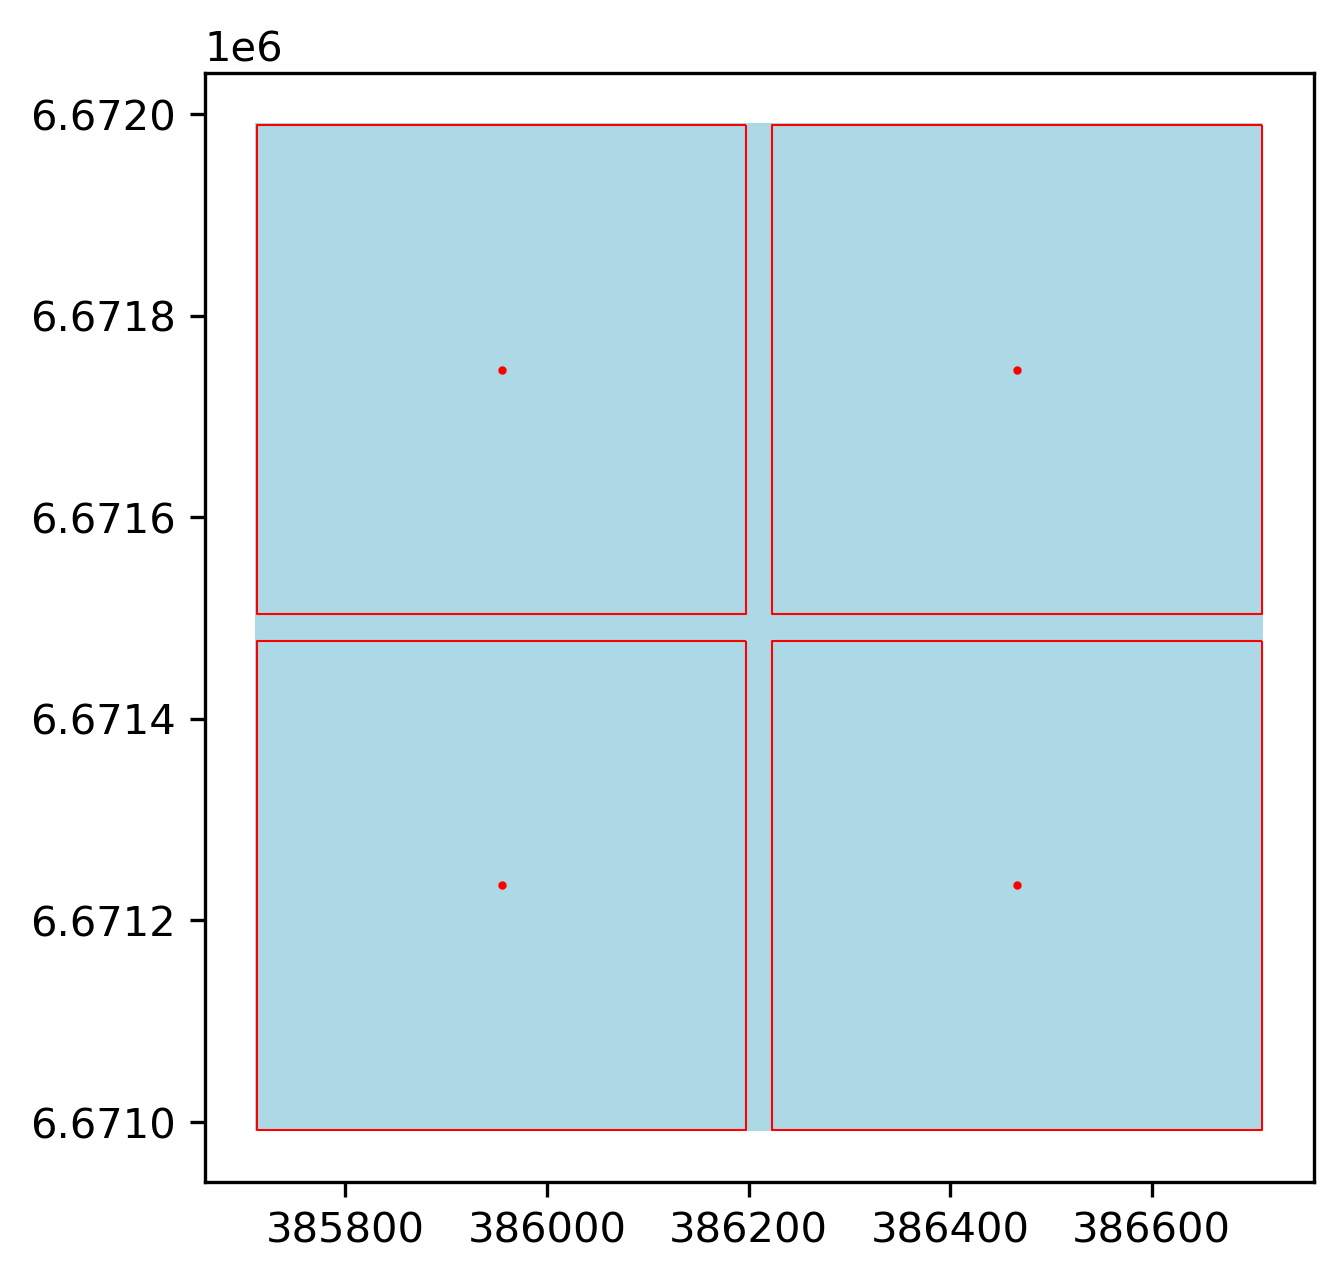

In [6]:
test_geo_series = geopd.GeoSeries([NW_sample, NE_sample, SE_sample, SW_sample])
ax = geopd.GeoSeries(poly).plot(color='lightblue')
ax = test_geo_series.plot(ax=ax, c='red', markersize=1)
ax = test_geo_series.buffer(sample_buffer_size_m, cap_style=3).boundary.plot(ax=ax, color='red', linewidth=0.5)

In [30]:
for sample in training_squares:
    print(sample)

POLYGON ((383199.6105259731 6867989.021773869, 383199.6105259731 6867501.725773869, 382712.3145259731 6867501.725773869, 382712.3145259731 6867989.021773869, 383199.6105259731 6867989.021773869))
POLYGON ((383708.93052597303 6867989.021773869, 383708.93052597303 6867501.725773869, 383221.63452597306 6867501.725773869, 383221.63452597306 6867989.021773869, 383708.93052597303 6867989.021773869))
POLYGON ((383708.93052597303 6867479.701773869, 383708.93052597303 6866992.405773869, 383221.63452597306 6866992.405773869, 383221.63452597306 6867479.701773869, 383708.93052597303 6867479.701773869))


In [17]:
print(clipped_annotation)

[<POLYGON ((383325.286 6867022.785, 383305.543 6867006.352, 383315.452 686699...>, <POLYGON ((383228.549 6867138.607, 383223.658 6867135.823, 383223.658 686714...>]


In [5]:
print(i)

605


In [6]:
print(j)

1818


In [3]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']